In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats

from ngboost import NGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
sales = pd.read_csv('dataset/sales.csv')

In [3]:
sales['date'] = pd.to_datetime(sales['date'])

In [4]:
sales.set_index('date', inplace=True)

In [5]:
sales_valid = sales[-12:] #Leaving some for validation
sales = sales[:-12]

In [6]:

sales_normalized = (sales-sales.mean())/sales.std()

<Axes: xlabel='Date', ylabel='Normalized Sales'>

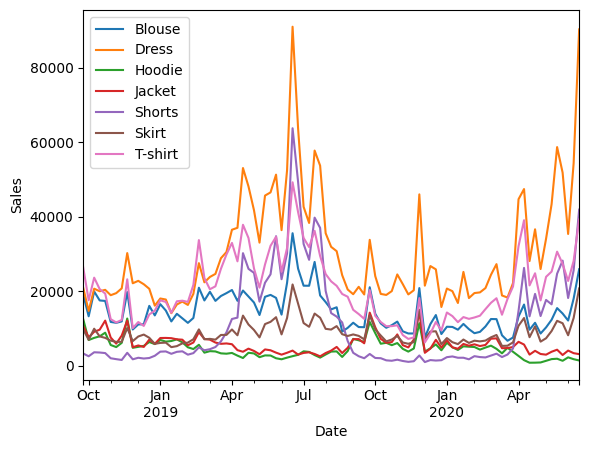

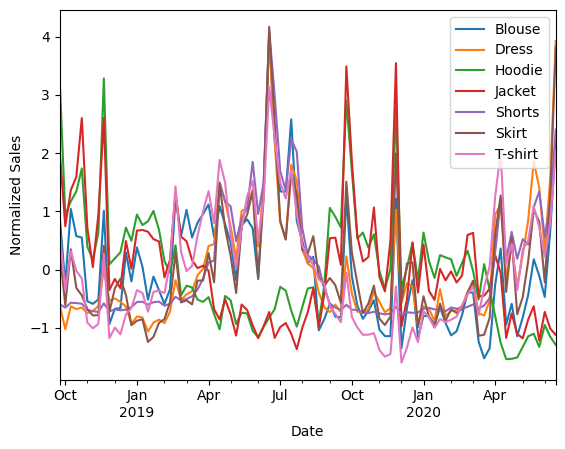

In [7]:
sales.plot(xlabel='Date', ylabel='Sales')
sales_normalized.plot(xlabel='Date', ylabel='Normalized Sales')

In [8]:
corr = sales.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=1)

,Blouse,Dress,Hoodie,Jacket,Shorts,Skirt,T-shirt
Blouse,1.0,0.7,-0.0,0.1,0.7,0.8,0.8
Dress,0.7,1.0,-0.5,-0.4,0.9,0.9,0.8
Hoodie,-0.0,-0.5,1.0,0.9,-0.6,-0.2,-0.4
Jacket,0.1,-0.4,0.9,1.0,-0.5,-0.1,-0.3
Shorts,0.7,0.9,-0.6,-0.5,1.0,0.8,0.9
Skirt,0.8,0.9,-0.2,-0.1,0.8,1.0,0.8
T-shirt,0.8,0.8,-0.4,-0.3,0.9,0.8,1.0


In [9]:
#dress and shorts/skirts strong correlation -> summer
#hoodie jacket go together -> winter
#blouse and t-shirt are more general, blouse is more season-resistant
#discount important, smaller peaks may be discount times
#black friday visible i think, in november there is small peak

# ARIMA

In this part I tried ARIMA, which I did not work well for me.

In [10]:
model = sm.tsa.statespace.SARIMAX(sales['Dress'], seasonal_order=(3, 1, 1,27))
results = model.fit(disp=False)


/home/dogac/cases/nycase/.conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/home/dogac/cases/nycase/.conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/home/dogac/cases/nycase/.conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Dress               mean       mean_se  mean_ci_lower  mean_ci_upper
2020-06-25  89435.377627  16211.185502   57662.037897  121208.717358
2020-07-02  97308.047007  21501.900867   55165.095707  139450.998306
2020-07-09  79682.725290  24775.588524   31123.464087  128241.986492
2020-07-16  63601.028032  26997.385665   10687.124451  116514.931613
2020-07-23  56879.785228  28569.174563     885.232017  112874.338439


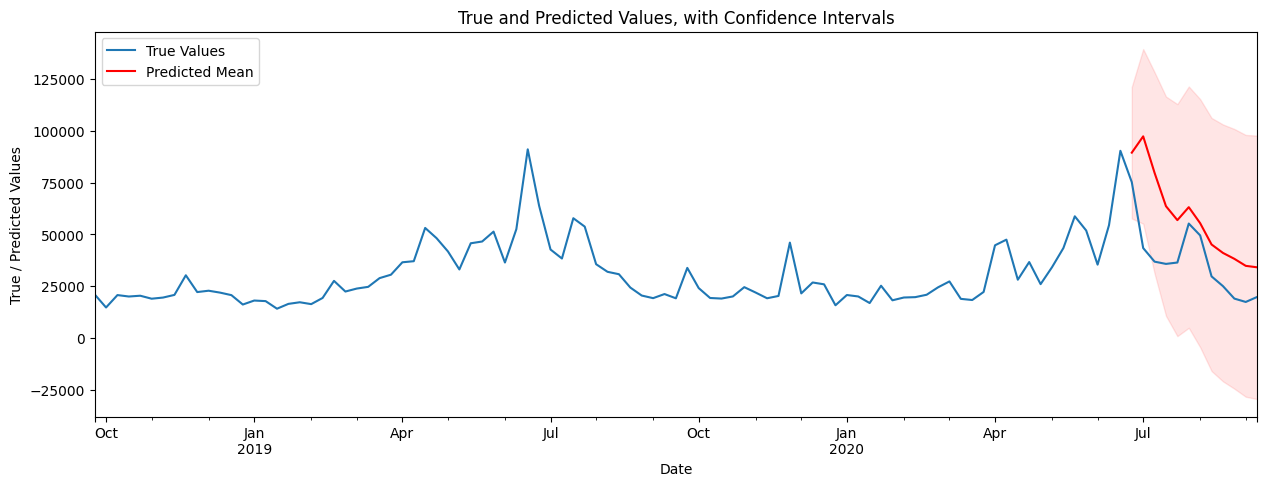

In [11]:
preds_df = (results
            .get_prediction(start='2020-06-25', end='2020-09-10')
            .summary_frame(alpha=0.05)
)
print(preds_df.head())


# Plot the training data, predicted means and confidence intervals
fig, ax = plt.subplots(figsize=(15,5))
ax = pd.concat([sales, sales_valid])['Dress'].plot(label='True Values')
ax.set(
    title='True and Predicted Values, with Confidence Intervals',
    xlabel='Date',
    ylabel='True / Predicted Values'
)
preds_df['mean'].plot(ax=ax, style='r', label='Predicted Mean')
ax.fill_between(
    preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'],
    color='r', alpha=0.1
)
legend = ax.legend(loc='upper left')
plt.show()

# NGBoost

Since the mean of the dataset is not increasing much as time passes, tree-based models are usable for this specific case.
NGBoost predicts a normal distribution around target, which can be naturally used as prediction intervals.


In [12]:
df = pd.concat([sales, sales_valid])
#Add the previous weeks' sale infos as features.
df_target = df['Dress']
df_s1 = df.shift(1)
df_s1.columns = [col + '_s1' for col in df_s1.columns]
df_s5 = df.shift(5) 
df_s5.columns = [col + '_s5' for col in df_s5.columns]
df_s12 = df.shift(12) # 3 Months ago
df_s12.columns = [col + '_s12' for col in df_s1.columns]

df_s53 = df.shift(53) #Year ago
df_s53.columns = [col + '_s53' for col in df_s53.columns]

train_dataset = pd.concat([df_s1['Dress_s1'], df_s5, df_s12, df_s53], axis=1).iloc[1:]
df_target = df_target.iloc[1:]
X_train = train_dataset.iloc[:-12]
X_valid = train_dataset.iloc[-12:]
y_train = df_target.iloc[:-12]
y_valid = df_target[-12:]

In [13]:
ngb = NGBRegressor(n_estimators=2000).fit(X_train.fillna(0), y_train)
Y_preds = ngb.predict(X_valid.fillna(0))
Y_dists = ngb.pred_dist(X_valid.fillna(0))

valid_MSE = mean_squared_error(Y_preds, y_valid)
valid_MAE = mean_absolute_error(Y_preds, y_valid)
print('Valid MSE:', valid_MSE, 'Valid MAE:',valid_MAE)

[iter 0] loss=11.0505 val_loss=0.0000 scale=1.0000 norm=11792.2186
[iter 100] loss=10.2778 val_loss=0.0000 scale=2.0000 norm=9828.3828
[iter 200] loss=9.5500 val_loss=0.0000 scale=2.0000 norm=4638.1252
[iter 300] loss=8.9978 val_loss=0.0000 scale=2.0000 norm=3053.0161
[iter 400] loss=8.5911 val_loss=0.0000 scale=1.0000 norm=1097.0183
[iter 500] loss=8.2446 val_loss=0.0000 scale=1.0000 norm=833.5924
[iter 600] loss=7.9475 val_loss=0.0000 scale=2.0000 norm=1311.8099
[iter 700] loss=7.6883 val_loss=0.0000 scale=1.0000 norm=528.5645
[iter 800] loss=7.4508 val_loss=0.0000 scale=1.0000 norm=431.1936
[iter 900] loss=7.2236 val_loss=0.0000 scale=2.0000 norm=703.2895
[iter 1000] loss=7.0270 val_loss=0.0000 scale=1.0000 norm=294.7215
[iter 1100] loss=6.8634 val_loss=0.0000 scale=1.0000 norm=253.3539
[iter 1200] loss=6.6698 val_loss=0.0000 scale=1.0000 norm=209.6312
[iter 1300] loss=6.4947 val_loss=0.0000 scale=0.5000 norm=89.1739
[iter 1400] loss=6.3269 val_loss=0.0000 scale=1.0000 norm=151.7731

In [14]:
ngb = NGBRegressor(n_estimators=2000).fit(train_dataset.fillna(0), df_target)



[iter 0] loss=11.0682 val_loss=0.0000 scale=1.0000 norm=12164.8155
[iter 100] loss=10.3809 val_loss=0.0000 scale=1.0000 norm=5552.3781
[iter 200] loss=9.6489 val_loss=0.0000 scale=2.0000 norm=5243.8575
[iter 300] loss=9.1109 val_loss=0.0000 scale=2.0000 norm=3639.6760
[iter 400] loss=8.7813 val_loss=0.0000 scale=1.0000 norm=1446.4546
[iter 500] loss=8.5122 val_loss=0.0000 scale=1.0000 norm=1174.7152
[iter 600] loss=8.2615 val_loss=0.0000 scale=1.0000 norm=952.0881
[iter 700] loss=8.0505 val_loss=0.0000 scale=1.0000 norm=800.6170
[iter 800] loss=7.8339 val_loss=0.0000 scale=1.0000 norm=666.8598
[iter 900] loss=7.6442 val_loss=0.0000 scale=1.0000 norm=560.8542
[iter 1000] loss=7.4681 val_loss=0.0000 scale=1.0000 norm=477.0374
[iter 1100] loss=7.3030 val_loss=0.0000 scale=0.5000 norm=206.2269
[iter 1200] loss=7.1671 val_loss=0.0000 scale=0.5000 norm=182.8184
[iter 1300] loss=7.0398 val_loss=0.0000 scale=0.5000 norm=163.2702
[iter 1400] loss=6.9317 val_loss=0.0000 scale=0.5000 norm=148.795

In [15]:
forecast_df = pd.DataFrame(columns=train_dataset.columns)

In [16]:
last_pred = ngb.predict(train_dataset.iloc[-1:])[0]

In [17]:
last_pred

19800.842642626525

In [18]:
#Produce forecast dataset for 5 weeks
for i in range(5):
    df_s5 = df.iloc[-5+i],
    df_s12 = df.iloc[-12+i],
    df_s53 = df.iloc[-53+i],
    row = pd.concat([ df.iloc[-12+i], df.iloc[-53+i]], axis=0)
    row = [last_pred]
    row.extend(list(df_s5[0]))
    row.extend(list(df_s12[0]))
    row.extend(list(df_s53[0]))
    
    forecast_df.loc[i] = list(row)
    last_pred = ngb.predict([forecast_df.iloc[i]])[0]


In [19]:
f_dist = ngb.pred_dist(forecast_df) # Get prediction distributions

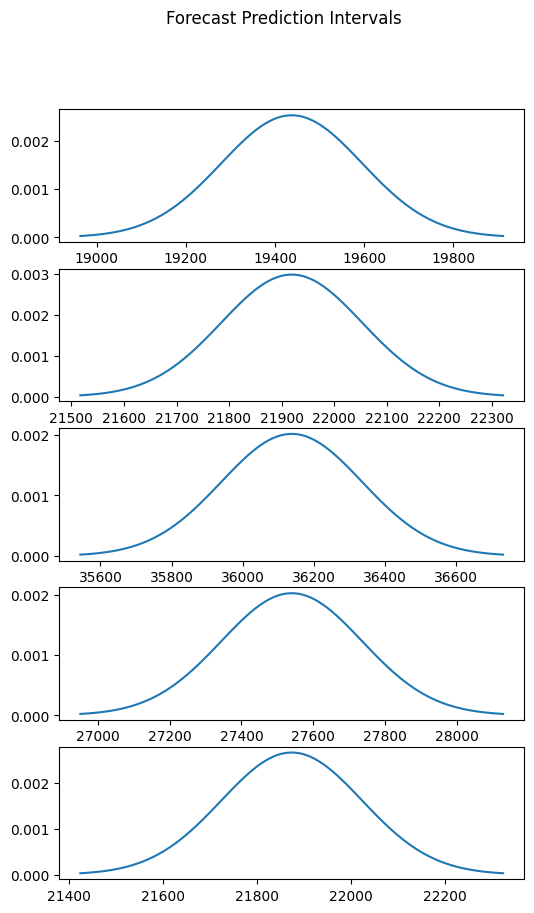

Predictions [19437.60792957 21919.27893408 36137.47951608 27539.87568097
 21874.02932018]


In [20]:
fig, axs = plt.subplots(5, figsize=(6,10))
fig.suptitle('Forecast Prediction Intervals')

for i in range(5):
    mean = f_dist.mean()[i]
    var = f_dist.var[i]
    sigma = np.sqrt(var)
    x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
    axs[i].plot(x, stats.norm.pdf(x, mean, sigma))
plt.show()
print('Predictions', f_dist.mean())